# Employee Turnover Prediction

---

Having stable workforce is vital for organisation's success by increasing productivity, cost effectiveness and institutional knowledge. This project aims to develop Random Survival Forest (RSF) model for predicting employee turnover, identify significantly-influential variables, and suggest intervention strategies.

Our data is from [IBM HR analytics synthetic data](https://github.com/IBM/employee-attrition-aif360/), analysed using R.

---

## Performing Data Wrangling

After importing the dataset, we first skim the data and check for data types, duplicates and empty values. Additionally, `summary()` can be perfomed into the dataset in order to check for unusual column ranges (not included here due to long print result).

In [1]:
# Importing data
rm(list = ls())
hr <- read.csv("emp_attrition.csv")

# First few rows.
head(hr)
# Number of duplicated rows
nrow(hr[duplicated(hr), ])
# Number of empty values
sum(is.na(hr))

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,⋯,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
,<int>,<chr>,<chr>,<int>,<chr>,<int>,<int>,<chr>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,⋯,1,80,0,8,0,1,6,4,0,5
2,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,⋯,4,80,1,10,3,3,10,7,1,7
3,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,⋯,2,80,0,7,3,3,0,0,0,0
4,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,⋯,3,80,0,8,3,3,8,7,3,0
5,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,⋯,4,80,1,6,3,3,2,2,2,2
6,32,No,Travel_Frequently,1005,Research & Development,2,2,Life Sciences,1,8,⋯,3,80,0,8,2,2,7,7,3,6


[1] 0

[1] 0

There are ways we could transform this data:

1. Some unnecessary variables for analysis, such as the one reflecting unique identification (that is, `EmployeeNumber`) and single-valued ones (such as `EmployeeCount`)

2. The string variables are apparently categorical.

We will remove any variable that represent unique identification, then remove single-valued variables and adjust the format of categorical variables. For the purpose of clarifying survival status in R's package, we convert variable `Attrition` into Boolean type.

There might be some cross-column consistency issues, particularly about time period (column: `Age`, `TotalWorkingYears`, `YearsAtCompany`, `YearsInCurrentRole`, `YearsSinceLastPromotion`, `YearsWithCurrManager`) and income rate (column: `DailyRate`, `HourlyRate`, `MonthlyIncome`, `MonthlyRate`). But since this is a synthetic data, we have less concerns and should skip this for now.

## Performing Additional Cleaning

In [2]:
remove_cols <- function(df, cols) df[, !(names(df) %in% cols)]

hr_emp_ids <- hr["EmployeeNumber"] # Save for backup
hr <- remove_cols(hr, c("EmployeeNumber"))
single_value_cols <- names(hr)[sapply(hr, function (col) length(unique(col)) == 1)]
hr <- remove_cols(hr, single_value_cols)

cat_cols <- c("BusinessTravel", "Department", "EducationField", "Gender", "JobRole", "MaritalStatus", "OverTime")
hr[cat_cols] <- lapply(hr[cat_cols], factor)

hr$Attrition <- ifelse(hr$Attrition == "Yes", TRUE, FALSE)

head(hr)

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,⋯,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
,<int>,<lgl>,<fct>,<int>,<fct>,<int>,<int>,<fct>,<int>,<fct>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,41,TRUE,Travel_Rarely,1102,Sales,1,2,Life Sciences,2,Female,⋯,3,1,0,8,0,1,6,4,0,5
2,49,FALSE,Travel_Frequently,279,Research & Development,8,1,Life Sciences,3,Male,⋯,4,4,1,10,3,3,10,7,1,7
3,37,TRUE,Travel_Rarely,1373,Research & Development,2,2,Other,4,Male,⋯,3,2,0,7,3,3,0,0,0,0
4,33,FALSE,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,4,Female,⋯,3,3,0,8,3,3,8,7,3,0
5,27,FALSE,Travel_Rarely,591,Research & Development,2,1,Medical,1,Male,⋯,3,4,1,6,3,3,2,2,2,2
6,32,FALSE,Travel_Frequently,1005,Research & Development,2,2,Life Sciences,4,Male,⋯,3,3,0,8,2,2,7,7,3,6


---

## Developing Initial Random Survival Forest Model

We develop Random Survival Forest model, available from R's library `randomForestSRC`. Initially we will use all our variables as the features, sparing `YearsAtCompanies` as the survival time variable and `Attrition` as status variable. To measure model's accuracy, we use Prediction Error Curve (PEC).

We then determine the overall importance score of features to understand what contributes to an employee's turnover. This is particularly important for feature selection in developing more lightweight model.

We will also output correlation analysis heatmap. To prevent variable clutters in the graph, we only consider numerical data for correlation map.


 randomForestSRC 3.2.2 
 
 Type rfsrc.news() to see new features, changes, and bug fixes. 
 


Loading required package: prodlim

Loading required package: viridisLite



[1] "Average variable importance:"
    YearsWithCurrManager                 OverTime       YearsInCurrentRole 
            3.211572e-02             2.492279e-02             2.062854e-02 
       TotalWorkingYears       NumCompaniesWorked                      Age 
            9.389286e-03             9.171343e-03             8.911440e-03 
                JobLevel            MonthlyIncome         StockOptionLevel 
            7.575671e-03             6.302221e-03             4.549840e-03 
                 JobRole          JobSatisfaction  EnvironmentSatisfaction 
            4.160096e-03             3.835192e-03             3.210597e-03 
        DistanceFromHome          WorkLifeBalance               Department 
            2.643675e-03             2.239384e-03             1.949085e-03 
          EducationField           JobInvolvement            MaritalStatus 
            1.722833e-03             1.685874e-03             1.590361e-03 
   TrainingTimesLastYear  YearsSinceLastPromotion    

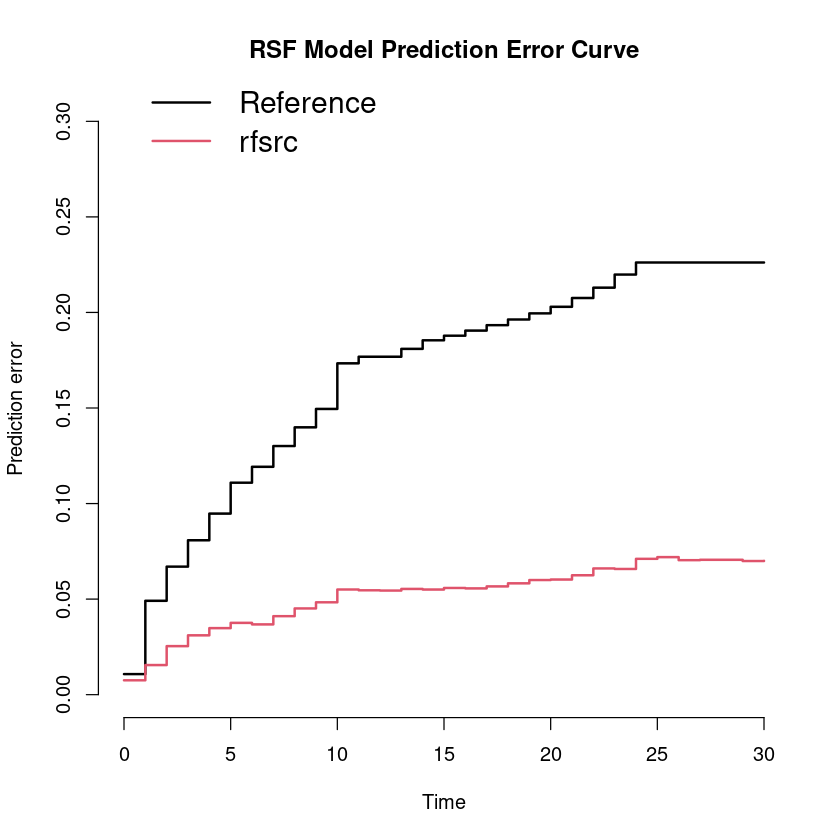

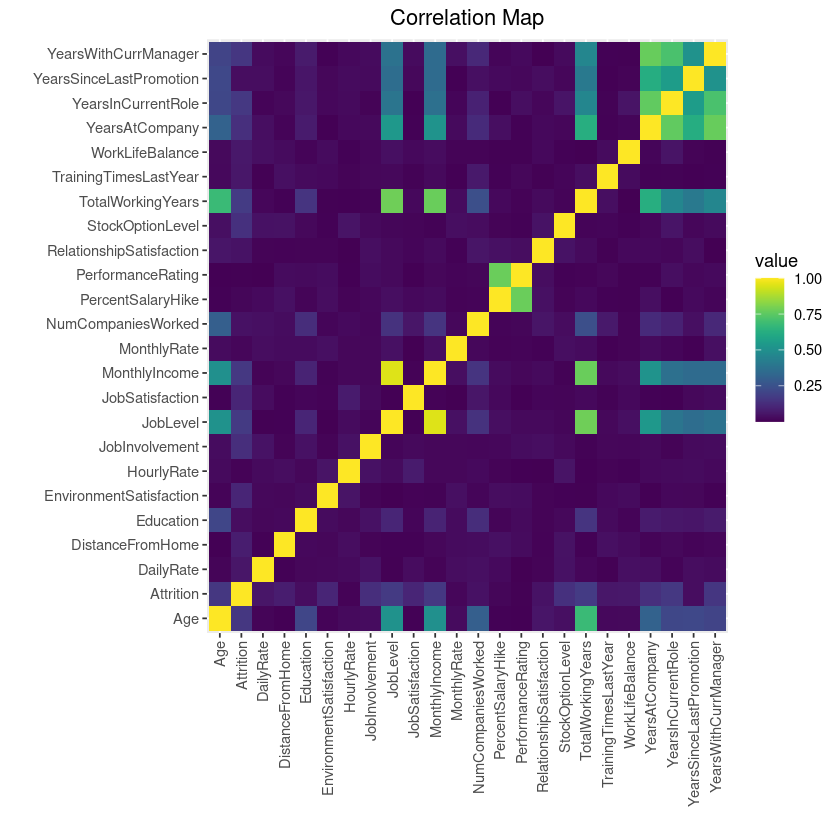

In [3]:
library(randomForestSRC)
library(survival)
library(pec, warn.conflicts = FALSE)
library(ggplot2)
library(reshape2)
library(viridis)

# Base model
rsf_model <- function (df) {
  model <- rfsrc(Surv(YearsAtCompany, Attrition) ~ ., data = df, ntree = 100)
  return(model)
}

# Accuracy plot
plot_pec <- function(df, model) {
  pred_error <- pec(model, data = df, formula = Surv(YearsAtCompany, Attrition) ~ .,
                    splitMethod = "none", cens.model = "marginal")
  plot(pred_error, xlim = c(0, 30), )
  title("RSF Model Prediction Error Curve")
}

# Feature selection functions
# 1. Importance function
rsf_importance <- function (df, model, sort = TRUE) {
  importance <- predict(model, df, importance = TRUE)$importance
  if (sort) {
      importance <- importance[order(importance, decreasing = TRUE)]
  }
  return(importance)
}

# 2. Averaged importance rank
train_test_generate <- function (df, proportion = 0.7) {
  size <- round(proportion * nrow(df))
  idx <- sample(seq_len(nrow(df)), size = size, replace = FALSE)
  return(list("train" = df[idx, ], "test" = df[-idx, ]))
}
k_fold_cross_val <- function (df, k = 10) {
  for (fold in 1:k) {
    separate <- train_test_generate(df)
    train <- separate$train
    test <- separate$test
    model <- rsf_model(train)
    if (!(exists("importance_tot"))) {
      importance_tot <- rsf_importance(test, model, FALSE)
    } else {
      importance_tot <- importance_tot + rsf_importance(test, model, FALSE)
    }
  }
  print("Average variable importance:")
  print(importance_tot[order(importance_tot, decreasing = TRUE)]/length(importance_tot))
}

# 3. Correlation
plot_correlation <- function (df, model) {
  cor_matrix <- cor(df[, !(names(df) %in% cat_cols)])
  melted_cor_matrix <- melt(cor_matrix)
  melted_cor_matrix$value <- abs(melted_cor_matrix$value)
  ggplot(data = melted_cor_matrix, aes(x = Var1, y = Var2, fill = value)) +
    geom_tile() + scale_fill_viridis() +
    xlab("") + ylab("") + ggtitle("Correlation Map") +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1),
         plot.title = element_text(hjust = 0.5))
}

# First iteration
model <- rsf_model(hr)
plot_pec(hr, model)
k_fold_cross_val(hr)
plot_correlation(hr, model)

The PEC graph shows that our model has around $75 - 95\%$ accuracy in predicting employee stay/turnover probability.

## Refining Our Model with Feature Selection

From the importance table, it seems that temporal variables such as `Age`, `TotalWorkingYears`, `YearsWithCurrManager`, `YearsInCurrentRole` dominates the model, which is a pretty-underwhelming insight: longer work history simply implies a closer time to the future turnover event. This is apparent from their correlations with the model's time variable `YearsAtCompany`. We will remove these from our next model.

The welfare-related variables such as `MonthlyIncome`, `Overtime` and `StockOptionLevel` seem make sense, and are not highly correlated with other variables, so we keep this. These variables also happen to be work-related, as opposed to something like `RelationshipSatisfaction`.

Other details are as follow:

1. The `Age` apparently does not correlate much with `YearsAtCompany`, and they are very common demography factor. We may keep this for now.

2. The `JobLevel` is highly tied to `MonthlyIncome`, while containing less information since it is a category. We remove this feature as a result.

3. `NumCompaniesWorked` and `JobRole` also perform pretty well. We consequently keep both variables.

4. We remove all other less influential features.

In particular, it might be interesting to explore the attrition levels grouped by `JobRole`:

In [4]:
library(dplyr)
hr[, c("Attrition", "JobRole", "MonthlyIncome")] %>%
  group_by(JobRole) %>%
  summarize(
    AttritionCount = sum(Attrition),
    TotalEmployees = n(),
    AttritionRate = AttritionCount/TotalEmployees
  )


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




JobRole,AttritionCount,TotalEmployees,AttritionRate
<fct>,<int>,<int>,<dbl>
Healthcare Representative,9,131,0.06870229
Human Resources,12,52,0.23076923
Laboratory Technician,62,259,0.23938224
Manager,5,102,0.04901961
Manufacturing Director,10,145,0.06896552
Research Director,2,80,0.02500000
Research Scientist,47,292,0.16095890
Sales Executive,57,326,0.17484663
Sales Representative,33,83,0.39759036


We can see that managerial position (Manager, Manufacturing Director, Research Director) and Healthcare Representation has around $5\%$ attrition rate, while general position sits at about $15-25\%$. I saw some online info that above $14\%$ churn rate is a 2021 average, so this is actually a pretty high job-quitting rate.

Sales reps roles are particularly prone to turnover (a whopping $40\%$) while also having a small number of employees. This is therefore a particular employee group that we need to focus on for mitigating their leaving.

## Developing Next Model

We perform previously described plan and redo our model. The PEC error is slightly higher but still no more than $25 \%$.

[1] "Average variable importance:"
     MonthlyIncome           OverTime                Age   StockOptionLevel 
        0.38536004         0.23388033         0.16947903         0.09439950 
           JobRole NumCompaniesWorked 
        0.08125495         0.07002217 


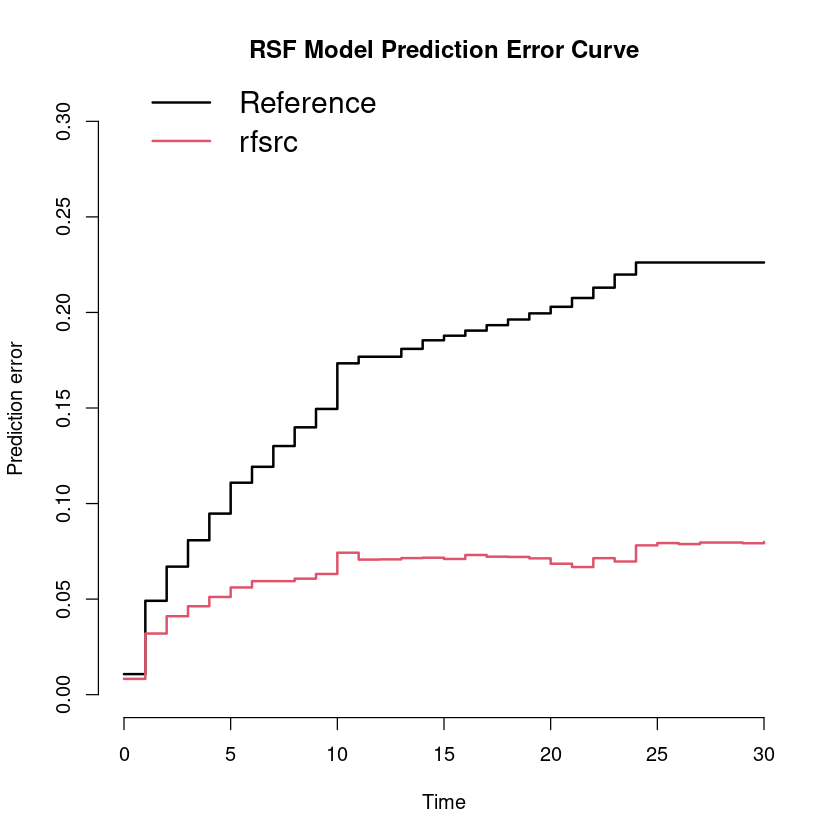

In [5]:
selected_features <- hr[, c("Attrition", "YearsAtCompany", "Age", "MonthlyIncome", "OverTime", "NumCompaniesWorked",
                            "StockOptionLevel", "JobRole")]
k_fold_cross_val(selected_features)
model_v2 <- rsf_model(selected_features)
plot_pec(selected_features, model_v2)

---

## Predicting Employee Turnover Result

We create the prediction of turnover probability of our employees in the next five years. We also identify 100 individuals at risk of leaving their jobs, ignoring the ones with positive turnover already. Some turnovers give probability higher than one, which is one of current model's limitations.

In [6]:
# Where do you see yourself in the next five years?
rsf_turnover_probability <- function (df, model) {
  return(predict(model, df)$chf)
}

for (i in 1:5) {
    hr[, paste0("AttritionProb_Year", i)] <- rsf_turnover_probability(hr, model_v2)[, i+1]
}
head(hr)

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,⋯,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,AttritionProb_Year1,AttritionProb_Year2,AttritionProb_Year3,AttritionProb_Year4,AttritionProb_Year5
,<int>,<lgl>,<fct>,<int>,<fct>,<int>,<int>,<fct>,<int>,<fct>,⋯,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,41,TRUE,Travel_Rarely,1102,Sales,1,2,Life Sciences,2,Female,⋯,1,6,4,0,5,0.135855956,0.251666009,0.281477203,0.29580397,0.46313719
2,49,FALSE,Travel_Frequently,279,Research & Development,8,1,Life Sciences,3,Male,⋯,3,10,7,1,7,0.001325926,0.001325926,0.001325926,0.00304017,0.00351636
3,37,TRUE,Travel_Rarely,1373,Research & Development,2,2,Other,4,Male,⋯,3,0,0,0,0,0.304369983,0.434497847,0.635269970,0.87891420,1.10466983
4,33,FALSE,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,4,Female,⋯,3,8,7,3,0,0.097031857,0.139754797,0.205618575,0.27707224,0.38484006
5,27,FALSE,Travel_Rarely,591,Research & Development,2,1,Medical,1,Male,⋯,3,2,2,2,2,0.054103129,0.143859108,0.177901323,0.31010621,0.34395172
6,32,FALSE,Travel_Frequently,1005,Research & Development,2,2,Life Sciences,4,Male,⋯,2,7,7,3,6,0.015642109,0.021614220,0.038284451,0.06021507,0.11182205


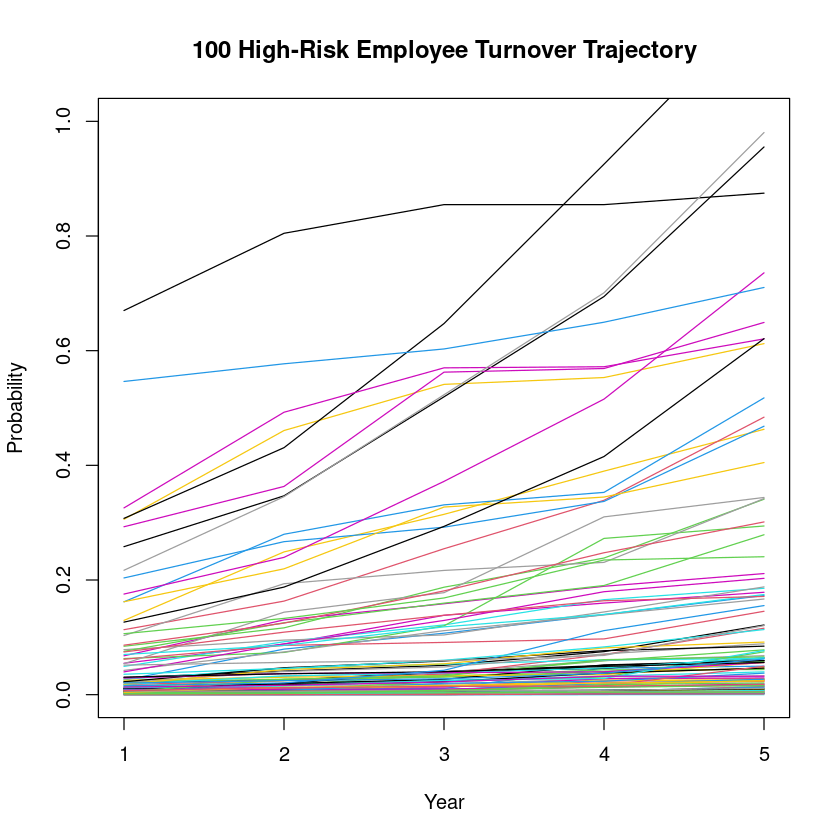

In [7]:
# Top individuals
rsf_high_risk_indiv_idx <- function (df, model, limit = 100) {
  df$HazardScore <- predict(model, df)$predicted
  return(order(df$HazardScore, decreasing = TRUE)[1:limit])
}

hriidx <- rsf_high_risk_indiv_idx(hr[hr["Attrition"] == FALSE, ], model_v2)
hrindv <- hr[hriidx, c("AttritionProb_Year1", "AttritionProb_Year2", "AttritionProb_Year3",
                                             "AttritionProb_Year4", "AttritionProb_Year5")]
plot(1, type = "n", xlim = c(1, ncol(hrindv)), ylim = c(0, 1), xlab = "Year", ylab = "Probability")
title("100 High-Risk Employee Turnover Trajectory")
for (i in 1:nrow(hrindv)) {
  lines(1:ncol(hrindv), hrindv[i, ], col = i, type = "l")
}
#legend("topright", legend = hr_emp_ids[hriidx, ], col = 1:nrow(hrindv), lty = 1, title = "EmpID")

## Recommended strategies

### Salary and Compensation Adjustment

Consider reviewing and maybe adjusting the salary structure to make sure it is competitive within the industry and region. Competitive salary system can help attract and retain talented employees.

### Overtime Management

Excessive overtime can lead to burnout among employees. Implement strategies to manage and reduce overtime, such as workload distribution, hiring additional staff, or arranging flexible work arrangements.

### Stock Option Incentives:

Consider expanding the stock option program to make it more attractive to employees. This could include granting stock options to a wider range of employees, offering more favorable terms, or providing education on the benefits of stock options.

### Retention Programs for Sales Reps

Our sales representatives are more prone to attrition. Implement retention programs specific to this group, such as performance-based incentives, career development paths, and mentorship programs.

### High Turnover History Analysis

Understand the reasons behind high turnover among employees with a history of working at multiple companies.

## Addition: Jupyter Link to Custom CSS

In [9]:
custom_css_html_txt <- "<link rel='stylesheet' type='text/css' href='https://github.com/ShuuheiAlb/shuuheialb.github.io/blob/main/projects/custom.css'>"
IRdisplay::display_html(custom_css_html_txt)